# **Setup & Imports**

In [ ]:
!nvidia-smi -L || echo "No GPU found. Enable GPU in Colab: Runtime > Change runtime type > Hardware accelerator = GPU"
import os, re, math, random, tarfile, urllib.request, shutil, time, gc
from pathlib import Path
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
try:
    import sklearn
    from sklearn.metrics import classification_report, confusion_matrix
except:
    !pip -q install scikit-learn
    from sklearn.metrics import classification_report, confusion_matrix
try:
    from tqdm import tqdm
except:
    !pip -q install tqdm
    from tqdm import tqdm
import matplotlib.pyplot as plt
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


GPU 0: Tesla T4 (UUID: GPU-5de8e51b-fc98-c232-4e3c-0ecea3d7e38e)
Device: cuda


# **Download & Extract IMDB Dataset**

In [ ]:
DATA_ROOT = Path("/content/data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
TGZ = DATA_ROOT / "aclImdb_v1.tar.gz"
DST = DATA_ROOT / "aclImdb"
if not DST.exists():
    if not TGZ.exists():
        urllib.request.urlretrieve(URL, TGZ)
    with tarfile.open(TGZ, "r:gz") as tar:
        tar.extractall(path=DATA_ROOT)
print("Folders:", list((DATA_ROOT/"aclImdb").iterdir()))


/tmp/ipython-input-1529539422.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_ROOT)


Folders: [PosixPath('/content/data/aclImdb/train'), PosixPath('/content/data/aclImdb/imdbEr.txt'), PosixPath('/content/data/aclImdb/README'), PosixPath('/content/data/aclImdb/imdb.vocab'), PosixPath('/content/data/aclImdb/test')]


# **Load Raw Texts & Simple Tokenizer**

In [ ]:
def read_split(split_dir):
    pos_dir = split_dir / "pos"
    neg_dir = split_dir / "neg"
    data = []
    for p in pos_dir.glob("*.txt"):
        data.append((p.read_text(encoding="utf-8", errors="ignore"), 1))
    for p in neg_dir.glob("*.txt"):
        data.append((p.read_text(encoding="utf-8", errors="ignore"), 0))
    random.shuffle(data)
    return data
train_raw = read_split(DST/"train")
test_raw  = read_split(DST/"test")
TOKEN_RE = re.compile(r"[A-Za-z0-9']+")
def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())
print("Train/Test sizes:", len(train_raw), len(test_raw))
print("Sample tokens:", tokenize("I LOVED it!! It's super-good, 10/10."))


Train/Test sizes: 25000 25000
Sample tokens: ['i', 'loved', 'it', "it's", 'super', 'good', '10', '10']


# **Build Vocabulary & Numericalize**

In [ ]:
VOCAB_SIZE = 20000
MIN_FREQ = 2
UNK, PAD = "<unk>", "<pad>"
counter = Counter()
for text, _ in tqdm(train_raw, desc="Building vocab"):
    counter.update(tokenize(text))
itos = [PAD, UNK]
for tok, freq in counter.most_common():
    if freq < MIN_FREQ: break
    if tok not in (PAD, UNK):
        itos.append(tok)
    if len(itos) >= VOCAB_SIZE:
        break
stoi = {tok:i for i, tok in enumerate(itos)}
vocab_size = len(itos)
print("Vocab size:", vocab_size)
def encode(text, max_len=256):
    toks = tokenize(text)
    ids = [stoi.get(t, stoi[UNK]) for t in toks][:max_len]
    if len(ids) < max_len:
        ids = ids + [stoi[PAD]]*(max_len-len(ids))
    return np.array(ids, dtype=np.int64)


Building vocab: 100%|██████████| 25000/25000 [00:02<00:00, 11589.94it/s]

Vocab size: 20000


# **Dataset & DataLoader**

In [ ]:
from sklearn.model_selection import train_test_split
MAX_LEN = 256
BATCH_SIZE = 128
train_pairs, val_pairs = train_test_split(train_raw, test_size=0.1, random_state=SEED, shuffle=True, stratify=[y for _, y in train_raw])
class IMDBDataset(Dataset):
    def __init__(self, pairs, max_len=256):
        self.texts = [t for t, _ in pairs]
        self.labels = [y for _, y in pairs]
        self.max_len = max_len
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        x = encode(self.texts[i], max_len=self.max_len)
        y = self.labels[i]
        return x, y
def collate_train(batch, drop_prob=0.05, pad_id=stoi["<pad>"]):
    xs = []
    for x,_ in batch:
        x = x.copy()
        if drop_prob > 0:
            mask = (np.random.rand(len(x)) < drop_prob)
            mask[x == pad_id] = False
            x[mask] = stoi["<unk>"]
        xs.append(x)
    xs = torch.tensor(xs, dtype=torch.long)
    ys = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return xs, ys
def collate_eval(batch):
    xs = torch.tensor([b[0] for b in batch], dtype=torch.long)
    ys = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return xs, ys
train_ds = IMDBDataset(train_pairs, MAX_LEN)
val_ds   = IMDBDataset(val_pairs,   MAX_LEN)
test_ds  = IMDBDataset(test_raw,    MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, collate_fn=collate_train, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_eval,   pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_eval,   pin_memory=True)
len(train_loader), len(val_loader), len(test_loader)


(176, 20, 196)

# **Define TextCNN Model**

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=2, kernel_sizes=(3,4,5), num_channels=128, dropout=0.5, pad_idx=0, emb_dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=embed_dim, out_channels=num_channels, kernel_size=k) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels*len(kernel_sizes), num_classes)
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    def forward(self, x):
        x = self.embedding(x)
        x = self.emb_dropout(x)
        x = x.transpose(1, 2)
        outs = []
        for conv in self.convs:
            h = F.relu(conv(x))
            h = F.max_pool1d(h, h.shape[-1]).squeeze(-1)
            outs.append(h)
        z = torch.cat(outs, dim=1)
        z = self.dropout(z)
        return self.fc(z)
model = TextCNN(vocab_size=vocab_size, embed_dim=128, num_classes=2, kernel_sizes=(3,4,5), num_channels=128, dropout=0.5, pad_idx=stoi["<pad>"], emb_dropout=0.1).to(device)
sum(p.numel() for p in model.parameters())/1e6


2.757762

# **Training & Evaluation**

In [ ]:
LR = 2e-3
EPOCHS = 8
WEIGHT_DECAY = 1e-2
MAX_NORM = 1.0
patience = 2
label_smoothing = 0.05

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total_loss, total_correct, total_count = 0.0, 0, 0
    for x, y in tqdm(loader, disable=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optimizer)
            scaler.update()
        pred = logits.argmax(1)
        total_correct += (pred == y).sum().item()
        total_count   += y.size(0)
        total_loss    += loss.item() * y.size(0)
    return total_loss/total_count, total_correct/total_count

best_val = float("inf")
best_state = None
hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
no_improve = 0

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader, train_mode=False)
    hist["train_loss"].append(train_loss); hist["train_acc"].append(train_acc)
    hist["val_loss"].append(val_loss); hist["val_acc"].append(val_acc)
    scheduler.step(val_loss)
    dt = time.time() - t0
    gap = val_loss - train_loss
    print(f"[Epoch {epoch}] train {train_loss:.4f}/{train_acc:.4f} | val {val_loss:.4f}/{val_acc:.4f} | loss_gap={gap:.4f} | {dt:.1f}s")
    if val_loss < best_val - 1e-4:
        best_val = val_loss
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping")
            break

if best_state is not None:
    model.load_state_dict(best_state)

Path("/content/ckpts").mkdir(parents=True, exist_ok=True)
torch.save({"state_dict": model.state_dict(), "vocab": itos, "stoi": stoi, "config": {"max_len": MAX_LEN}}, "/content/ckpts/textcnn_imdb_best.pth")
print("Saved best model to /content/ckpts/textcnn_imdb_best.pth")


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[Epoch 1] train 1.3567/0.5694 | val 0.6019/0.6520 | loss_gap=-0.7548 | 7.8s


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[Epoch 2] train 0.6703/0.6363 | val 0.5388/0.7208 | loss_gap=-0.1316 | 4.9s


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[Epoch 3] train 0.6261/0.6727 | val 0.4964/0.7920 | loss_gap=-0.1297 | 5.3s


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  1%|          | 1/176 [00:00<00:33,  5.28it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.

[Epoch 4] train 0.5984/0.7002 | val 0.5069/0.7420 | loss_gap=-0.0915 | 5.5s


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[Epoch 5] train 0.5803/0.7155 | val 0.4594/0.7988 | loss_gap=-0.1209 | 7.7s


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[Epoch 6] train 0.5670/0.7318 | val 0.4872/0.7712 | loss_gap=-0.0798 | 6.8s


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[Epoch 7] train 0.5360/0.7497 | val 0.4893/0.7740 | loss_gap=-0.0467 | 5.0s
Early stopping
Saved best model to /content/ckpts/textcnn_imdb_best.pth


# **Curves, Metrics, Confusion Matrix, Report**

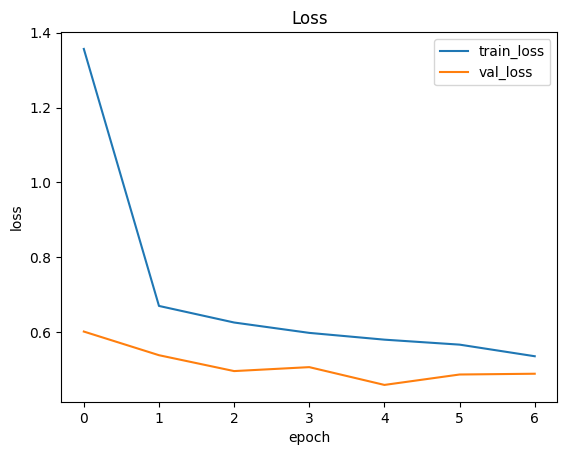

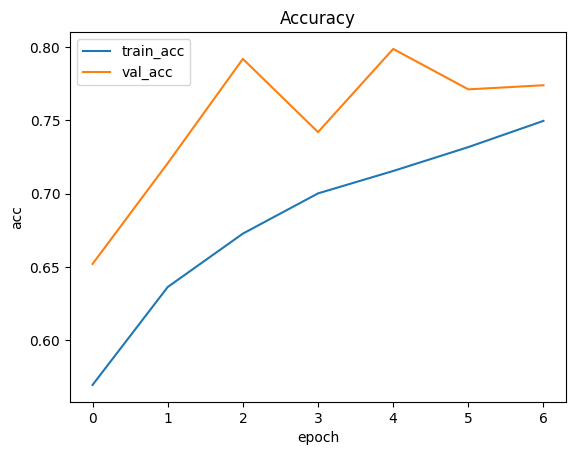

/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor([b[0] for b in batch], dtype=torch.long)
/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor([b[0] for b in batch], dtype=torch.long)


              precision    recall  f1-score   support

         neg     0.8619    0.6911    0.7671     12500
         pos     0.7422    0.8893    0.8091     12500

    accuracy                         0.7902     25000
   macro avg     0.8021    0.7902    0.7881     25000
weighted avg     0.8021    0.7902    0.7881     25000

Confusion matrix:
 [[ 8639  3861]
 [ 1384 11116]]


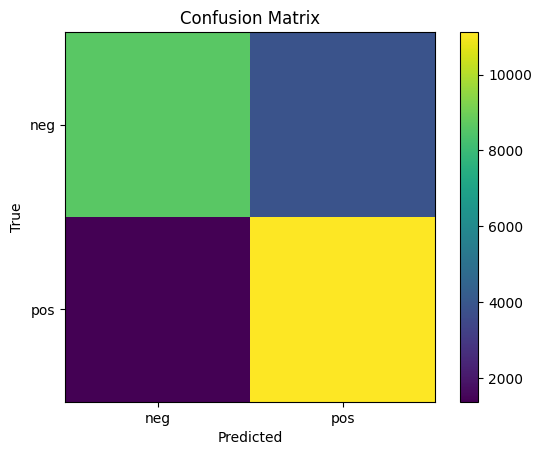

In [ ]:
plt.figure()
plt.plot(hist["train_loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.show()
plt.figure()
plt.plot(hist["train_acc"], label="train_acc")
plt.plot(hist["val_acc"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.show()
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(1).cpu().numpy().tolist()
        y_pred.extend(pred); y_true.extend(y.numpy().tolist())
print(classification_report(y_true, y_pred, target_names=["neg","pos"], digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick = np.arange(2)
plt.xticks(tick, ["neg","pos"])
plt.yticks(tick, ["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# **Quick Inference Helper**

In [ ]:
id2label = {0:"neg", 1:"pos"}
def predict_sentiment(text: str):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(encode(text, MAX_LEN), dtype=torch.long).unsqueeze(0).to(device)
        logits = model(x)
        prob = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
        return id2label[int(prob.argmax())], float(prob.max())
print(predict_sentiment("I absolutely loved this movie, it was fantastic!"))
print(predict_sentiment("Boring plot and terrible acting. Waste of time."))


('neg', 0.5820559859275818)
('neg', 0.977288544178009)


# **FIne-Tune**

In [ ]:
ckpt_path = "/content/ckpts/textcnn_imdb_best.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt["state_dict"])

FT_EPOCHS = 5
FT_LR = 5e-4
FT_WD = 5e-3
FT_PATIENCE = 3
MAX_NORM = 1.0
label_smoothing = 0.02

optimizer = torch.optim.AdamW(model.parameters(), lr=FT_LR, weight_decay=FT_WD)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

best_val = float("inf")
best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
no_improve = 0
hist_ft = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total_loss, total_correct, total_count = 0.0, 0, 0
    for x, y in tqdm(loader, disable=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optimizer)
            scaler.update()
        pred = logits.argmax(1)
        total_correct += (pred == y).sum().item()
        total_count   += y.size(0)
        total_loss    += loss.item() * y.size(0)
    return total_loss/total_count, total_correct/total_count

for epoch in range(1, FT_EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader,   False)
    hist_ft["train_loss"].append(tr_loss); hist_ft["val_loss"].append(va_loss)
    hist_ft["train_acc"].append(tr_acc);   hist_ft["val_acc"].append(va_acc)
    scheduler.step(va_loss)
    print(f"[FT {epoch}] train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= FT_PATIENCE:
            print("Early stopping (fine-tune).")
            break

model.load_state_dict(best_state)
torch.save({"state_dict": model.state_dict(), "vocab": itos, "stoi": stoi, "config": {"max_len": MAX_LEN}}, "/content/ckpts/textcnn_imdb_finetuned.pth")
print("Saved /content/ckpts/textcnn_imdb_finetuned.pth")


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[FT 1] train 0.5117/0.7527 | val 0.4318/0.8096


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[FT 2] train 0.4991/0.7590 | val 0.4222/0.8148


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[FT 3] train 0.4940/0.7641 | val 0.4259/0.8108


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[FT 4] train 0.4952/0.7656 | val 0.4267/0.8136


  0%|          | 0/176 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
/tmp/ipython-input-2559519293.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor(xs, dtype=torch.long)
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Trigger

[FT 5] train 0.4838/0.7720 | val 0.4149/0.8212
Saved /content/ckpts/textcnn_imdb_finetuned.pth


In [ ]:
model.eval()
probs_val, labels_val = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
        probs_val.extend(p.tolist())
        labels_val.extend(y.numpy().tolist())

import numpy as np
def f1_at_threshold(th):
    pred = (np.array(probs_val) >= th).astype(int)
    from sklearn.metrics import f1_score
    return f1_score(labels_val, pred, average="macro")

ths = np.linspace(0.3, 0.7, 81)
scores = [f1_at_threshold(t) for t in ths]
best_idx = int(np.argmax(scores))
best_th = float(ths[best_idx])
best_f1 = float(scores[best_idx])
print("Best threshold on val:", best_th, "macro-F1:", best_f1)


/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor([b[0] for b in batch], dtype=torch.long)
/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor([b[0] for b in batch], dtype=torch.long)


Best threshold on val: 0.5499999999999999 macro-F1: 0.8239350954335807


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy()
        pred = (p >= best_th).astype(int).tolist()
        y_pred.extend(pred)
        y_true.extend(y.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=["neg","pos"], digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor([b[0] for b in batch], dtype=torch.long)
/tmp/ipython-input-2559519293.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  xs = torch.tensor([b[0] for b in batch], dtype=torch.long)


              precision    recall  f1-score   support

         neg     0.8107    0.8249    0.8177     12500
         pos     0.8218    0.8074    0.8145     12500

    accuracy                         0.8161     25000
   macro avg     0.8162    0.8161    0.8161     25000
weighted avg     0.8162    0.8161    0.8161     25000

Confusion matrix:
 [[10311  2189]
 [ 2408 10092]]


In [ ]:
ckpt_path = "/content/ckpts/textcnn_imdb_finetuned.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt["state_dict"])
id2label = {0:"neg", 1:"pos"}

def predict_sentiment(text: str, th: float=None):
    t = th if th is not None else (best_th if "best_th" in globals() else 0.5)
    model.eval()
    with torch.no_grad():
        x = torch.tensor(encode(text, MAX_LEN), dtype=torch.long).unsqueeze(0).to(device)
        logits = model(x)
        p = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
        pred = 1 if p[1] >= t else 0
        return {"label": id2label[pred], "prob_pos": float(p[1]), "prob_neg": float(p[0]), "threshold": float(t)}

def predict_batch(texts, th: float=None):
    t = th if th is not None else (best_th if "best_th" in globals() else 0.5)
    model.eval()
    X = [encode(z, MAX_LEN) for z in texts]
    with torch.no_grad():
        x = torch.tensor(X, dtype=torch.long).to(device)
        logits = model(x)
        P = torch.softmax(logits, dim=-1).cpu().numpy()
    out = []
    for p in P:
        pred = 1 if p[1] >= t else 0
        out.append({"label": id2label[pred], "prob_pos": float(p[1]), "prob_neg": float(p[0]), "threshold": float(t)})
    return out

print(predict_sentiment("I absolutely loved this movie, it was fantastic!"))
print(predict_sentiment("Boring plot and terrible acting. Waste of time."))
print(predict_sentiment("The production is passable, the in game economy is abysmal. Even if the gameplay is fun, there's so much more  game out there that it's not worth the time."))
print(predict_sentiment("fantastic movie!!"))
print(predict_sentiment("So Boring asf"))
print(predict_sentiment("Clown no more.7 years of wait were not wasted.A sequel deserving the status as one of the best Metroidvania..."))
print(predict_sentiment("Just a shocking amount of game here. Rolled (final) credits at 100 hours with 86% completion. Had a great time, in spite of the difficulty, but I think there are some aspects of the game that really disrespect your time, and which could have been adjusted. Might expand a little on this later after thinking on it a bit, but there are a lot of small irritants scattered throughout that I think add up to mar an otherwise tremendous game."))
print(predict_sentiment("Nothing in this works, the characters aren’t even believable to their own setting, and the praise just confuses me, do I really have to believe this is one of the best romance anime ever made? The answer is a no, given CloverWorks’ track record this season, deciding to vomit 3 anime at the same time and even putting them in the same promotions means that you have to expect something of the quality of the other two, and in fact, that’s exactly what you get, but unlike Sono Bisque Doll that had a nice first season and Bunny Girl Senpai that while it started awful it actually got a little better with time, you have this thing right here, which was easily the worst of the three. The story wants to have its cake and eat it too, the source of all the drama is the opposite of what we see on our screens, and the only thing that could “stop” their romance is a conflict that makes no sense. There’s nothing here that makes me want to support this romance, because everything here feels fake, manufactured, illogical and unbelievable, it’s the opposite of realistic in every possible way."))
print(predict_sentiment("As an adaptation, CITY is incredibly ambitious and transformative. Through cuts and edits and restructuring of the material and sometimes even small expansions, the anime becomes something distinct from the manga and yet completely inseparable from it. Sacrificing some of CITY's interconnected, the anime brings to mind a bigger focus on the spontaneity of the CITY itself and the sheer amount of joy each day can bring. That said, for how large the CITY cast performs a herculean effort in trying to showcase each and every one and even the small appearances help to incentive just how larger and life the CITY is. Small things like sometimes seeing one character run in the background to the ever so brilliant 5th episode that depicts multiple threads of the characters within their own wacky situations that eventually coalesce in a moment of brilliance help sell the CITY as something that is always moving and fully alive. It is an adaptation that co-exists with it's source material in a beautiful way, allowing one to experience the CITY from different angles and constantly be rewarded with revisits between both the manga and the anime. Above all, as a fan of the studio who has been following the studio for more than 10 years, seeing the studio produce a work this full of joy and wonder brings me to the brink of tears. It is no exaggeration to say that I have rewatched the final 3 minutes of the show and been brought to tears of joy. It's a finale that emphasizes the value of community, the ways acts of kindness both direct and indirect can bring us together in the most unlikeliest of ways, and the importance of finding the fun in everyday life. It's a beautiful piece of art that the fact it exists as it does brings me so much joy that I still cannot believe it exists. Thank you Ishidate and Arawi and Kyoani as a whole for coming together to produce possibly the most joyous experience I ever had following an seasonal anime in years."))
print(predict_sentiment("yes the animation isn't something out of studio WIT. Yes the soundtrack isn't top 10 and yes the voice actors aren't as good as kazuma having a conversation with aqua but this anime feels... familiar... comfortable because this is not the daily lives of immortal highschool boys, not the daily lives of highschool boys in another world nor the daily lives of highschool boys dxd. Its just the daily lives of highschool boys. Its the sense of equality or relatability with a show that makes a viewer relax and laugh to their heart's content, and theres no doubt this show can do that. If you're not a guy you'd probably won't relate as well to the reasoning behind the male character's actions, choices of vocabulary or reasoning of emotions, but i'd say give it a try. Plus theres a small segment at each episode on high school girls"))
print(predict_sentiment("I really enjoyed the first few episodes of this anime, the premise was very exciting. A shy, timid witch with social anxiety so severe she can't even talk to most people is tasked with doing espionage in order to protect an important political figure from assassination. Although Monica is a witch of great talent, she must conceal her true power in order to hide her identity. This premise is nothing short of awesome, and that's why this show is so disappointing. It doesn't do anything with it.The first issue I noticed was the pacing, there is way too much emphasis being put on Monica's interactions with other members of her school, and not enough emphasis put on the actual plot of the show. Conflicts are introduced, and then immediately solved in the next episode so the anime can go back to being about nothing. Once a conflict is resolved, it stops mattering just as quickly. Sometimes they'll bring up the would-be assassin in casual conversation, but there's no weight to it.However, there are two sides to the plot, the assassination attempts are only one side. So what about the other one? Monica's personal growth as a person. She does exhibit growth throughout the anime, but it's not very well written. At all. Over the course of the story, she slowly becomes less and less anxious and more able to speak up for herself, but these instances of growth aren't shown, it isn't a gradual thing, and doesn't feel natural. Monica is never meaningfully challenged, so the moments where she grows feel arbitrary and random.If this adaptation was handled better, I think this anime could have been really great. The conflicts that Monica would face in her mission would directly relate to her relationships with other characters and her growth as a person; But that is not the story we got. Instead, the adaptation prefers to focus, as much as possible, on cute wholesome interactions between characters, and the assassination plot line is something just begrudgingly included because it's part of the story"))
print(predict_sentiment("All right, it is high time to wrap up this incomprehensible wall of text masquerading as a thoughtful review. I want to end it by simply encouraging anyone who has yet to see Frieren to cave in and give it a shot. In the worst-case scenario, you will not be wowed by what it has to offer, and you will either power through its episodes as a reluctant passenger or abandon ship entirely. However, if it is your cup of tea and clicks with you, it will be an experience unlike any other.In any case, I sincerely think Frieren deserves our attention and adoration and must be treasured for years to come. It is a nearly flawless and intensely special anime that, I kid you not, excels in every aspect. I feel fortunate to have been part of this joyful and adventurous journey for so long, and my love for it is as vast and endless as its world."))

{'label': 'neg', 'prob_pos': 0.457978755235672, 'prob_neg': 0.5420212149620056, 'threshold': 0.5499999999999999}
{'label': 'neg', 'prob_pos': 0.009249170310795307, 'prob_neg': 0.9907508492469788, 'threshold': 0.5499999999999999}
{'label': 'neg', 'prob_pos': 0.5212358832359314, 'prob_neg': 0.4787641167640686, 'threshold': 0.5499999999999999}
{'label': 'neg', 'prob_pos': 0.3990761339664459, 'prob_neg': 0.6009238362312317, 'threshold': 0.5499999999999999}
{'label': 'neg', 'prob_pos': 0.17033495008945465, 'prob_neg': 0.8296650648117065, 'threshold': 0.5499999999999999}
{'label': 'pos', 'prob_pos': 0.8870176076889038, 'prob_neg': 0.11298242956399918, 'threshold': 0.5499999999999999}
{'label': 'pos', 'prob_pos': 0.6036044359207153, 'prob_neg': 0.39639556407928467, 'threshold': 0.5499999999999999}
{'label': 'neg', 'prob_pos': 0.03999633714556694, 'prob_neg': 0.960003674030304, 'threshold': 0.5499999999999999}
{'label': 'pos', 'prob_pos': 0.7312121391296387, 'prob_neg': 0.2687878906726837, 'th

# **วาดภาพ Architecture**

In [ ]:
!pip -q install graphviz torchviz torchview

import torch
from torchviz import make_dot

m = model if 'model' in globals() else model_xl
m.eval()
dummy = torch.randint(0,  min(20000, getattr(m.embedding, 'num_embeddings', 20000)), (1, int(globals().get('MAX_LEN',256)))).to(next(m.parameters()).device)
out = m(dummy)
dot = make_dot(out, params=dict(list(m.named_parameters())))
dot.format = 'png'
path = dot.render('/content/textcnn_autograd')
path

from torchview import draw_graph
import torch

m = model if 'model' in globals() else model_xl
m.eval()

L = int(globals().get('MAX_LEN', 256))
V = m.embedding.num_embeddings
dev = next(m.parameters()).device

x_long = torch.randint(0, V, (1, L), dtype=torch.long, device=dev)

g = draw_graph(
    m,
    input_data=x_long,
    expand_nested=True,
    roll=True,
    graph_name="TextCNN"
)
g.visual_graph.render('/content/textcnn_torchview', format='png')
'/content/textcnn_torchview.png'



'/content/textcnn_torchview.png'

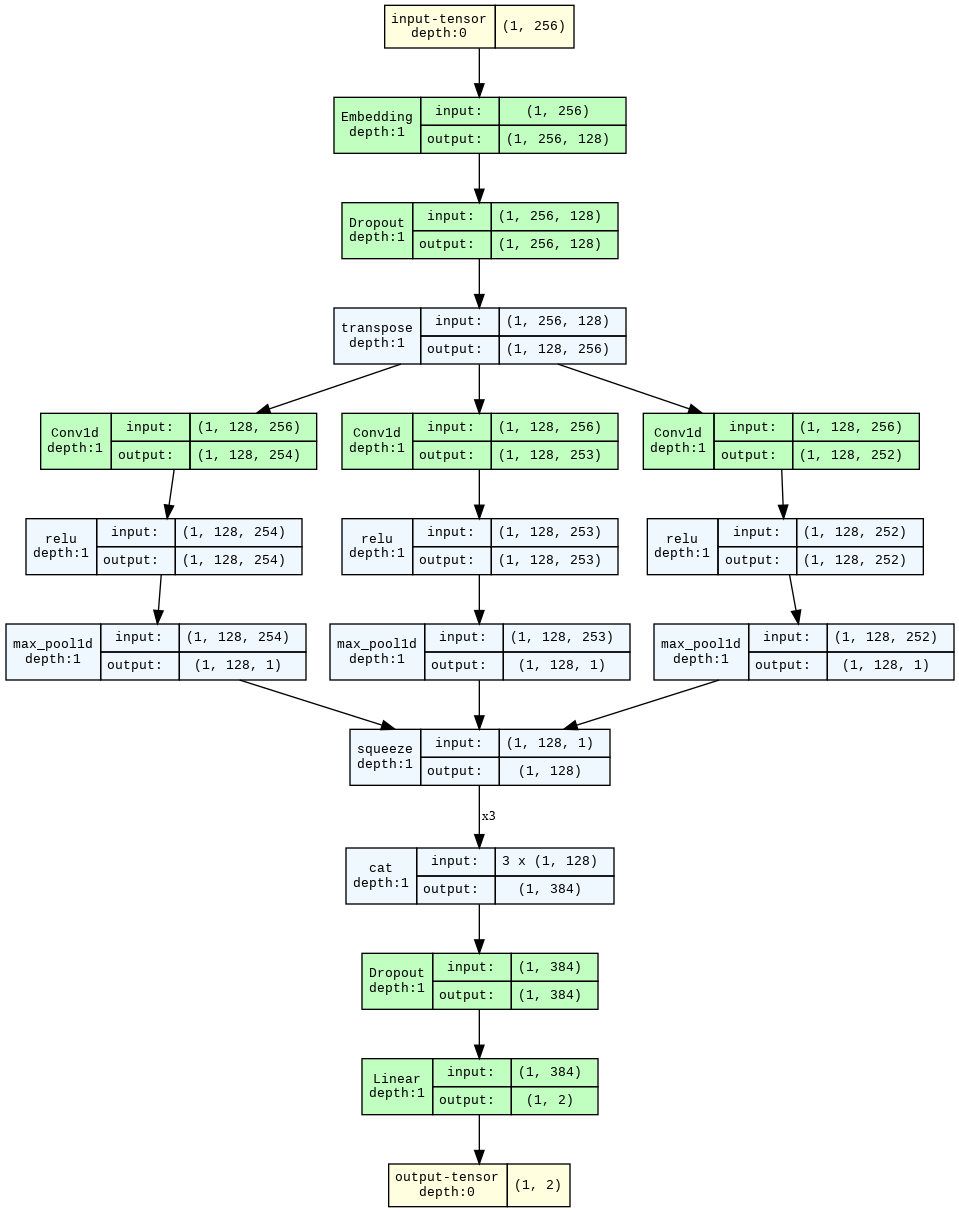

In [35]:

from torchview import draw_graph
import torch
from IPython.display import Image, display

m = model if 'model' in globals() else model_xl
m.eval()

L = int(globals().get('MAX_LEN', 256))
V = m.embedding.num_embeddings
dev = next(m.parameters()).device
x_long = torch.randint(0, V, (1, L), dtype=torch.long, device=dev)

g = draw_graph(m, input_data=x_long, expand_nested=True, roll=True, graph_name="TextCNN")
g.resize_graph(scale=1.4)
out_path = g.visual_graph.render('/content/textcnn_torchview', format='png', cleanup=True)

display(Image(filename='/content/textcnn_torchview.png'))
